In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import lil_matrix, csr_matrix

In [ ]:
import pandas as pd
import numpy as np
poster = pd.read_csv('/content/drive/MyDrive/기학팀플/포스터/movies_with_posters_info.csv')
data = pd.read_csv('/content/drive/MyDrive/기학팀플/movie.csv')

In [ ]:
poster.head()

,movie_title,poster_url,poster_path,path_exists,poster_features
0,Percy Jackson & the Olympians: The Lightning T...,https://image.tmdb.org/t/p/w500/8wmqmvJknPv6Wp...,/content/drive/MyDrive/기학팀플/포스터/posters_extrac...,True,[2.352482 0.8196823 0.6109686 ... 0.107919...
1,Please Give,https://image.tmdb.org/t/p/w500/kft7oy2SoImjDU...,/content/drive/MyDrive/기학팀플/포스터/posters_extrac...,True,[0.06859249 0.42631173 0.35531956 ... 2.242278...
2,10,https://image.tmdb.org/t/p/w500/rQpGG43cv25Ckg...,/content/drive/MyDrive/기학팀플/포스터/posters_extrac...,True,[0.53212035 0.9425426 0.9476789 ... 0.288133...
3,12 Angry Men (Twelve Angry Men),https://image.tmdb.org/t/p/w500/ow3wq89wM8qd5X...,/content/drive/MyDrive/기학팀플/포스터/posters_extrac...,True,[0.34569138 0.3404254 0. ... 0.552213...
4,"20,000 Leagues Under The Sea",https://image.tmdb.org/t/p/w500/heAEH85fdxEgV9...,/content/drive/MyDrive/기학팀플/포스터/posters_extrac...,True,[0.06518269 0.47282863 0.35711354 ... 0. ...


In [ ]:
print(poster['poster_features'][1])

[0.06859249 0.42631173 0.35531956 ... 2.2422788  0.4955135  0.2493618 ]


In [ ]:
import re
import numpy as np

# Step 1: 포스터 특징 데이터를 numpy 배열로 변환
def parse_features(feature):
    # 쉼표 추가를 위해 공백을 쉼표로 변환
    corrected = re.sub(r'\s+', ',', feature.strip()[1:-1])  # 양쪽 대괄호 제거 후 쉼표 추가
    return np.array(eval(f"[{corrected}]"))

poster_features = np.array([parse_features(feature) for feature in poster['poster_features']])

# 변환 결과 확인
print(poster_features.shape)  # (데이터 개수, 특징 개수)
print(poster_features[5])     # 첫 번째 데이터 확인


(17021, 7)
[0.12606072 0.1734944 1.1409943 Ellipsis 0.0307393 0.2051936 0.2511689]


In [ ]:
import re
import numpy as np

def parse_features_fixed(feature):
    # 쉼표 추가를 위해 공백을 쉼표로 변환
    corrected = re.sub(r'\s+', ',', feature.strip()[1:-1])  # 대괄호 제거 후 쉼표 추가
    array = eval(f"[{corrected}]")  # 배열로 변환

    # Python 객체 Ellipsis를 0으로 대체
    array = [0 if val is Ellipsis else val for val in array]
    return np.array(array)

poster_features = np.array([parse_features_fixed(feature) for feature in poster['poster_features']])

# 변환 결과 확인
print(poster_features.shape)  # (데이터 개수, 특징 개수)
print(poster_features[5])     # 특정 데이터 확인


(17021, 7)
[0.12606072 0.1734944  1.1409943  0.         0.0307393  0.2051936
 0.2511689 ]


In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: K-Means 클러스터링 수행
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
poster['cluster'] = kmeans.fit_predict(poster_features)

# Step 2: 각 클러스터에서 중심과 가장 가까운 영화 5개 선택
cluster_representatives = {}

for cluster_id in range(num_clusters):
    cluster_indices = poster[poster['cluster'] == cluster_id].index
    cluster_vectors = poster_features[cluster_indices]

    # 클러스터 중심 계산
    cluster_center = kmeans.cluster_centers_[cluster_id]

    # 중심과의 거리 계산
    distances = np.linalg.norm(cluster_vectors - cluster_center, axis=1)
    closest_indices = cluster_indices[np.argsort(distances)[:5]]  # 가장 가까운 5개

    # 결과 저장
    cluster_representatives[cluster_id] = closest_indices

# Step 3: 결과 출력
for cluster_id, indices in cluster_representatives.items():
    print(f"Cluster {cluster_id}:")
    for idx in indices:
        print(f" - {poster.loc[idx, 'movie_title']}")
    print()


Cluster 0:
 - Factory Girl
 - Alexandra
 - Nicholas and Alexandra
 - Dancing at Lughnasa
 - The Baytown Outlaws

Cluster 1:
 - Bye Bye Birdie
 - Playing for Keeps
 - Murder at 1600
 - Eulogy
 - Pick of the Litter

Cluster 2:
 - The Decoy Bride
 - Merlin
 - Opportunity Knocks
 - The Big Ugly
 - Mortal Engines

Cluster 3:
 - Shaolin
 - Shaolin Soccer
 - Guta-yubalja-deul (A Bloody Aria)
 - The Claim
 - The Return of the Living Dead

Cluster 4:
 - Delta of Venus
 - Venus
 - Henri Langlois: The Phantom of the Cinematheque
 - Sherlock Gnomes
 - The Rookie



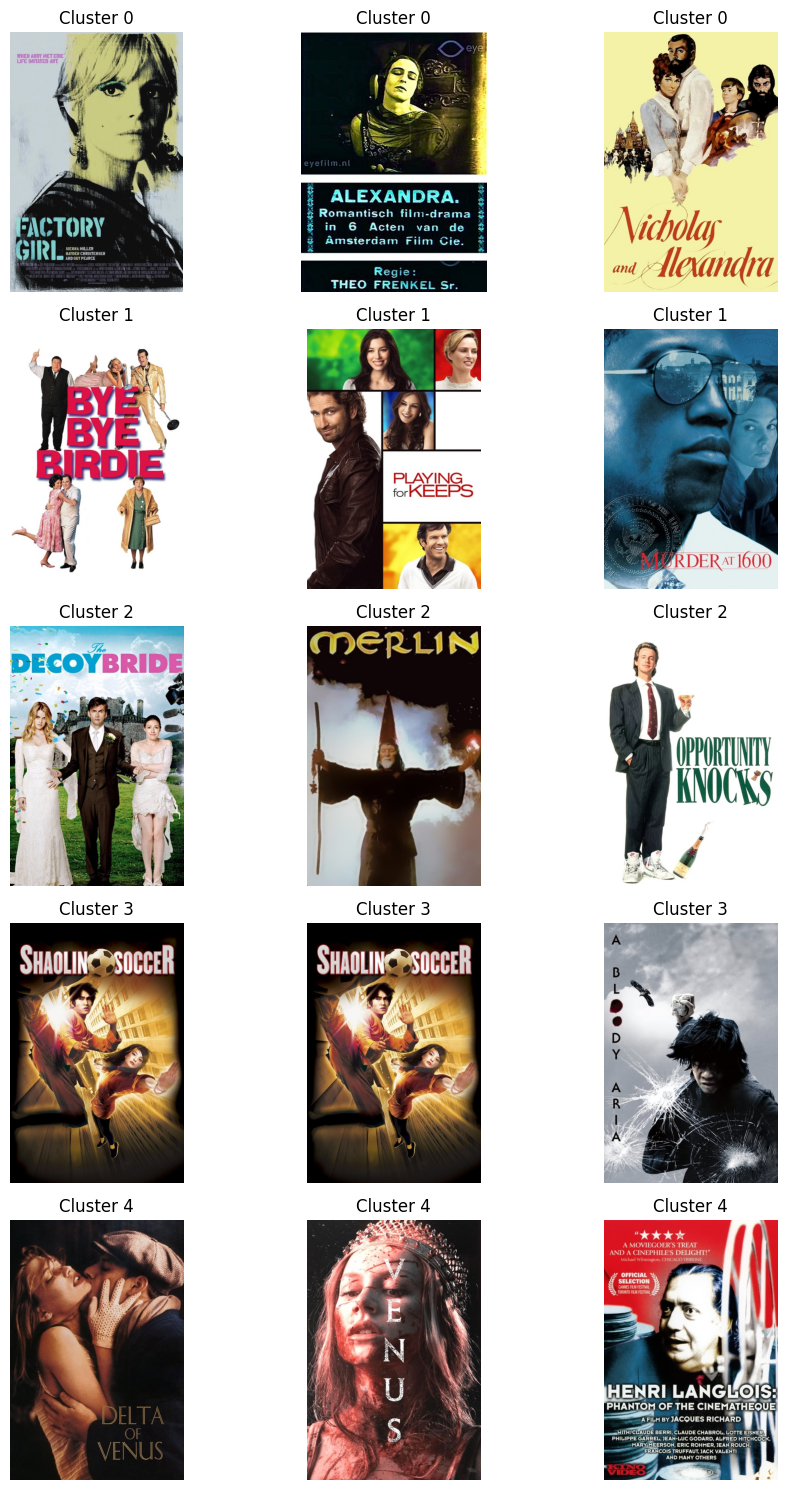

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

# Step 1: K-Means 클러스터링 수행
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
poster['cluster'] = kmeans.fit_predict(poster_features)

# Step 2: 각 클러스터에서 중심과 가까운 영화 5개 선택
cluster_representatives = {}

for cluster_id in range(num_clusters):
    cluster_indices = poster[poster['cluster'] == cluster_id].index
    cluster_vectors = poster_features[cluster_indices]

    # 클러스터 중심 계산
    cluster_center = kmeans.cluster_centers_[cluster_id]

    # 중심과의 거리 계산
    distances = np.linalg.norm(cluster_vectors - cluster_center, axis=1)
    closest_indices = cluster_indices[np.argsort(distances)[:3]]  # 가장 가까운 5개

    # 결과 저장
    cluster_representatives[cluster_id] = closest_indices

# Step 3: 클러스터별 포스터 시각화
plt.figure(figsize=(15, 15))
for cluster_id, indices in cluster_representatives.items():
    for i, idx in enumerate(indices):
        plt.subplot(num_clusters, 5, cluster_id * 5 + i + 1)

        # 포스터 이미지 불러오기
        poster_url = poster.loc[idx, 'poster_url']  # 포스터 URL
        try:
            response = requests.get(poster_url)
            img = Image.open(BytesIO(response.content))
        except:
            img = Image.new('RGB', (500, 750), (255, 255, 255))  # 빈 이미지 생성 (에러 대비)

        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Cluster {cluster_id}")

plt.tight_layout()
plt.show()
